# 08 Exercise ML Comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# NLP librerie
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Scikit-learn
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# Download NLTK data
for resource in [
    'punkt', 'stopwords', 'wordnet',
    'punkt_tab', 'omw-1.4',
]:
    nltk.download(resource, quiet=True)

np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Using device: {device}")
print("Setup completato")

import os, urllib.request, joblib

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu', tokenizer=None):
    """Load pretrained weights if available, otherwise train and save.
    If tokenizer is provided, its word_index is saved/loaded alongside the weights
    to ensure vocabulary consistency.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')
    vocab_path = weights_path.replace('.pt', '_vocab.json')

    def _load_weights(path):
        model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
        # Restore tokenizer vocabulary if saved alongside weights
        if tokenizer is not None and os.path.exists(vocab_path):
            import json as _json
            with open(vocab_path, 'r') as f:
                tokenizer.word_index = _json.load(f)
            print(f"  Restored tokenizer vocabulary ({len(tokenizer.word_index)} words)")

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        _load_weights(weights_path)
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            # Also try downloading vocabulary
            if tokenizer is not None:
                try:
                    urllib.request.urlretrieve(
                        WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_vocab.json'), vocab_path)
                except Exception:
                    pass
            # Also try downloading history
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            _load_weights(weights_path)
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    # Save history
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    # Save tokenizer vocabulary alongside weights
    if tokenizer is not None:
        import json as _json
        with open(vocab_path, 'w') as f:
            _json.dump(tokenizer.word_index, f)
        print(f"Saved tokenizer vocabulary to {vocab_path}")
    return history

Using device: cuda
Setup completato


In [3]:
# Caricamento dataset IMDB
from datasets import load_dataset

# Carica IMDB da Hugging Face datasets
imdb_dataset = load_dataset('imdb')

X_train_text = np.array(imdb_dataset['train']['text'])
y_train_imdb = np.array(imdb_dataset['train']['label'])
X_test_text = np.array(imdb_dataset['test']['text'])
y_test_imdb = np.array(imdb_dataset['test']['label'])

# Shuffle training e test set (il dataset HuggingFace
# e' ordinato per label, la versione Keras era shuffled)
rng = np.random.RandomState(42)
train_shuffle = rng.permutation(len(X_train_text))
X_train_text = X_train_text[train_shuffle]
y_train_imdb = y_train_imdb[train_shuffle]

test_shuffle = rng.permutation(len(X_test_text))
X_test_text = X_test_text[test_shuffle]
y_test_imdb = y_test_imdb[test_shuffle]

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")

# Visualizza esempi
print("\nReview 1 (Positiva):")
pos_idx = np.where(y_train_imdb == 1)[0][0]
print(X_train_text[pos_idx][:500])
print(
    f"\nSentiment: "
    f"{'Positivo' if y_train_imdb[pos_idx] == 1 else 'Negativo'}"
)
print("\n" + "=" * 60 + "\n")

# Trova una review negativa
neg_idx = np.where(y_train_imdb == 0)[0][0]
print("Review 2 (Negativa):")
print(X_train_text[neg_idx][:500])
print(
    f"\nSentiment: "
    f"{'Positivo' if y_train_imdb[neg_idx] == 1 else 'Negativo'}"
)

print(f"\nDataset: {len(X_train_text)} train, "
      f"{len(X_test_text)} test")
print(f"Esempio: {X_train_text[0][:200]}...")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training samples: 25000
Test samples: 25000

Review 1 (Positiva):
I dug out from my garage some old musicals and this is another one of my favorites. It was written by Jay Alan Lerner and directed by Vincent Minelli. It won two Academy Awards for Best Picture of 1951 and Best Screenplay. The story of an American painter in Paris who tries to make it big. Nina Foch is a sophisticated lady of means and is very interested in helping him, but soon finds she loves the guy. Meanwhile Gene Kelly falls for lovely damsel, Leslie Caron. His main dancing partner, and I m

Sentiment: Positivo


Review 2 (Negativa):
Dumb is as dumb does, in this thoroughly uninteresting, supposed black comedy. Essentially what starts out as Chris Klein trying to maintain a low profile, eventually morphs into an uninspired version of "The Three Amigos", only without any laughs. In order for black comedy to work, it must be outrageous, which "Play Dead" is not. In order for black comedy to work, it cannot be mean spi

## Esercizio 3

**Task**: Trainare e confrontare 4 modelli ML classici
(Naive Bayes, Logistic Regression, SVM, Random Forest)
su review IMDB con TF-IDF features. Usare cross-validation
per una valutazione robusta.

Esercizio 3 - Train: (2400, 5000), Test: (600, 5000)

CONFRONTO MODELLI
              model  test_accuracy  cv_mean   cv_std
        Naive Bayes       0.848333 0.837500 0.013819
         Linear SVM       0.840000 0.830833 0.018133
Logistic Regression       0.830000 0.838333 0.019392
      Random Forest       0.783333 0.794583 0.013346


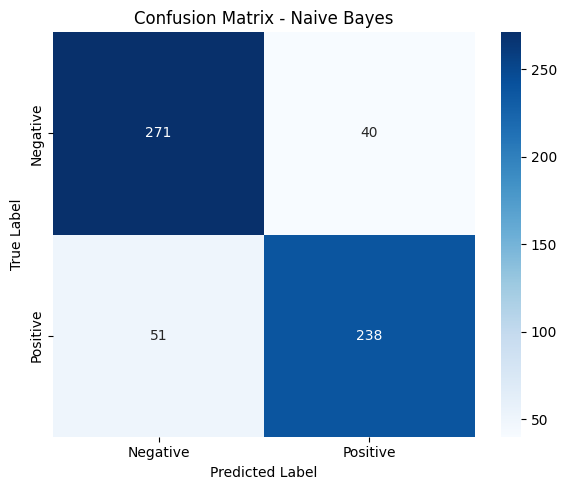


CLASSIFICATION REPORT - Naive Bayes
              precision    recall  f1-score   support

    Negative       0.84      0.87      0.86       311
    Positive       0.86      0.82      0.84       289

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

Esercizio 3 completato


In [13]:
# =========================================================
# ESERCIZIO 3: Confronto Modelli ML Classici
# =========================================================
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Subset dedicato (3000 campioni per avere risultati
# realistici ma non troppo lento)
ex3_n = 3000
ex3_X = X_train_text[:ex3_n]
ex3_y = y_train_imdb[:ex3_n]

# Split train/test
ex3_X_train, ex3_X_test, ex3_y_train, ex3_y_test = \
    train_test_split(
        ex3_X, ex3_y,
        test_size=0.2,
        random_state=42,
        stratify=ex3_y,
    )

# TF-IDF features
ex3_vectorizer = TfidfVectorizer(
    max_features=5000, ngram_range=(1, 2),
    min_df=3, max_df=0.85,
)
ex3_X_train_tfidf = ex3_vectorizer.fit_transform(
    ex3_X_train
)
ex3_X_test_tfidf = ex3_vectorizer.transform(ex3_X_test)

print(f"Esercizio 3 - Train: {ex3_X_train_tfidf.shape}, "
      f"Test: {ex3_X_test_tfidf.shape}")

# Scrivi la tua soluzione qui
raise NotImplementedError()